In [1]:
import os
import re
import cv2
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from TrainDataset import TrainDataset
from TestDataset import TestDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
%matplotlib inline
from utils import resize_image, restore_image, apply_bm3d_denoiser, add_padding, remove_padding, save_image, normalize, generate_phi
from ourModel import Model
from skimage.metrics import peak_signal_noise_ratio as psnr
import time
torch.cuda.empty_cache()

In [2]:
test_file_name = 'robot.jpg'
measurement_rate = 0.1


compression_percentage = int(100*measurement_rate)
name='model_state_Our_new_model_2fclayer_200_epoch_' + str(compression_percentage) + '_compression_rate'
model_name = name +'.pth'
compression_rate = measurement_rate
ratio_dict = {1: 10, 4: 43, 10: 109, 25: 272, 30: 327, 40: 436, 50: 545}

In [3]:
mat = generate_phi(ratio_dict[compression_percentage], 1089)
mat = torch.from_numpy(mat)

In [4]:
import torch
import time
import numpy as np
from torch.optim.lr_scheduler import StepLR

transformations = transforms.Compose([transforms.ToTensor()])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = Model(ratio_dict, compression_percentage, measurement_rate=compression_rate)
model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

criterion = nn.MSELoss()
criterion = criterion.to(device)

state_dict = torch.load(model_name,map_location ='cpu')
model.load_state_dict(state_dict)
model.eval()

DataParallel(
  (module): Model(
    (fc1): Linear(in_features=109, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=1089, bias=True)
    (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

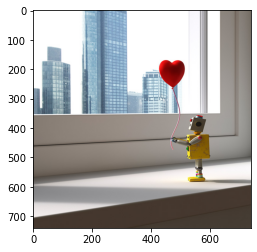

In [5]:
test_img = plt.imread(test_file_name)
plt.imshow(test_img)

In [6]:
torch.cuda.empty_cache()

In [7]:
# Function to process a generic channel with smaller batches
def process_channel_with_batches(channel_data, model, criterion, batch_size):
    h, w = channel_data.shape
    stride = 14
    filter_size = 33
    h_n = ((h - filter_size) // stride) + 1
    w_n = ((w - filter_size) // stride) + 1

    reconstructed_channel = np.zeros((h, w))

    for i in range(0, h_n * w_n, batch_size):
        batch_images = []
        for j in range(i, min(i + batch_size, h_n * w_n)):
            idx = j
            row = idx // w_n
            col = idx % w_n
            block = channel_data[row * stride:(row * stride) + filter_size, col * stride:(col * stride) + filter_size]
            batch_images.append(block)

        batch_images = np.array(batch_images)

        test_data = TestDataset(batch_images, mat, transformations, compression_rate)
        test_dl = DataLoader(test_data, batch_size=len(batch_images))

        # Model Output
        inp, lbl = next(iter(test_dl))
        inp = inp.cuda().float()
        lbl = lbl.cuda().float()

        out = model(inp)
        out = out.view(lbl.size())
        loss = criterion(out, lbl)
        #print('Test Loss:', loss.item())

        # Calculate PSNR
        out_cpu = out.detach().cpu().numpy()
        lbl_cpu = lbl.detach().cpu().numpy()
        psnr_value = psnr(lbl_cpu, out_cpu)
#         print('Test PSNR:', psnr_value)

        # Reconstruct the image
        out = out.view(-1, 33, 33).cpu().detach().numpy()

        for j, k in enumerate(range(i, min(i + batch_size, h_n * w_n))):
            row = k // w_n
            col = k % w_n
            reconstructed_channel[row * stride:(row * stride) + filter_size, col * stride:(col * stride) + filter_size] = out[j]

    return reconstructed_channel


In [8]:
# Load the image
test_img = plt.imread(test_file_name)
#test_img = resize_image(test_img, 256, 256)
original_image = test_img
test_img = add_padding(test_img)
#test_img = resize_image(test_img, 256, 256)
x_dim, y_dim, _ = test_img.shape


# Convert to YCbCr color space
test_img_ycbcr = cv2.cvtColor(test_img, cv2.COLOR_RGB2YCrCb)

# Normalize the image
test_img_ycbcr = cv2.normalize(test_img_ycbcr, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Separate the channels
y_channel = test_img_ycbcr[:, :, 0]
cb_channel = test_img_ycbcr[:, :, 1]
cr_channel = test_img_ycbcr[:, :, 2]

# Create a placeholder for reconstructed image
reconstructed_img_ycbcr = np.zeros(test_img.shape)
reconstructed_y_channel = np.zeros_like(y_channel)
reconstructed_cb_channel = np.zeros_like(cb_channel)
reconstructed_cr_channel = np.zeros_like(cr_channel)


model.load_state_dict(torch.load(model_name, map_location='cpu'))
model = model.cuda()
model.eval()

criterion = nn.MSELoss()

# Define batch size for processing
batch_size = 1089  # Adjust this according to your GPU memory capacity

# Process Y channel with smaller batches
reconstructed_y_channel = process_channel_with_batches(y_channel, model, criterion, batch_size)

# Process Cb channel with smaller batches
reconstructed_cb_channel = process_channel_with_batches(cb_channel, model, criterion, batch_size)

# Process Cr channel with smaller batches
reconstructed_cr_channel = process_channel_with_batches(cr_channel, model, criterion, batch_size)

# Merge channels
reconstructed_img_ycbcr = np.zeros(test_img.shape)
reconstructed_img_ycbcr[:, :, 0] = reconstructed_y_channel
reconstructed_img_ycbcr[:, :, 1] = reconstructed_cb_channel
reconstructed_img_ycbcr[:, :, 2] = reconstructed_cr_channel

# Convert back to RGB
reconstructed_img_ycbcr_uint8 = np.clip(reconstructed_img_ycbcr * 255, 0, 255).astype(np.uint8)
reconstructed_img_rgb = cv2.cvtColor(reconstructed_img_ycbcr_uint8, cv2.COLOR_YCrCb2RGB)

# Display or save the reconstructed RGB image
# plt.axis('off')
# plt.imshow(remove_padding(reconstructed_img_rgb))
# plt.title('Reconstructed RGB Image')
# plt.savefig('./images/sample_result_RGB.png', bbox_inches='tight', pad_inches=0)
# plt.show()


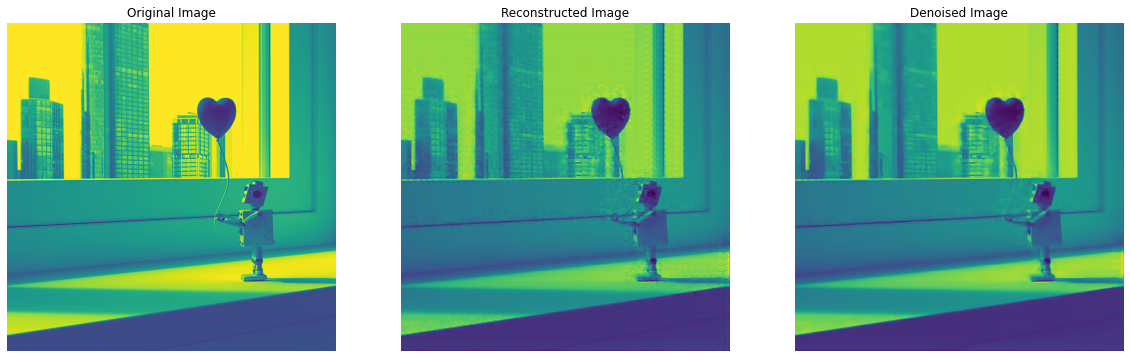

In [9]:
# Load the image
rgb_image = reconstructed_y_channel

# Set the standard deviation of the noise (adjust as needed)
sigma = 0.1

# Apply BM3D denoiser
denoised_image = apply_bm3d_denoiser(rgb_image, sigma)

# Display the original and denoised images
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(remove_padding(y_channel))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(remove_padding(rgb_image))
plt.title('Reconstructed Image')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(remove_padding(denoised_image))
plt.title('Denoised Image')

plt.show()

In [10]:
psnr_ = psnr(remove_padding(y_channel).astype(np.float64), remove_padding(rgb_image).astype(np.float64))
print("Reconstructed Image PSNR:", psnr_)

psnr_denoised = psnr(remove_padding(y_channel).astype(np.float64), remove_padding(denoised_image).astype(np.float64))
print("Denoised Image PSNR:", psnr_denoised)


Reconstructed Image PSNR: 27.51728650654529
Denoised Image PSNR: 27.863526431864337


Text(0.5, 1.0, 'Denoised Image')

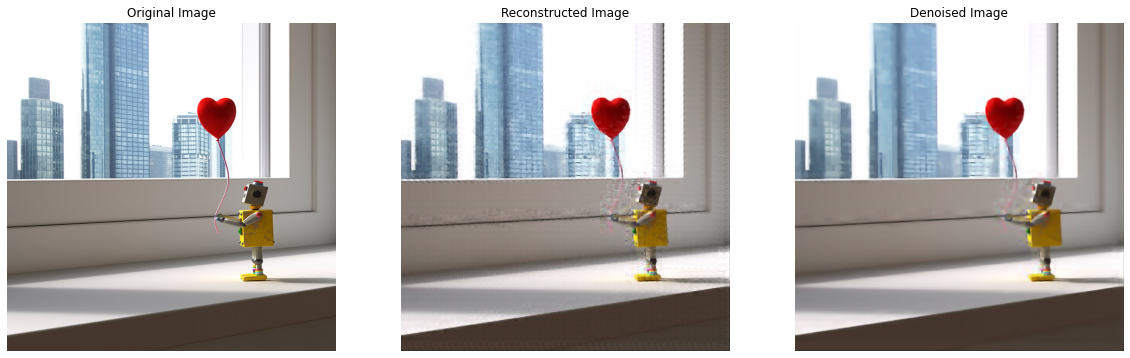

In [11]:
reconstructed_denoised_img = np.stack((denoised_image, reconstructed_cb_channel, reconstructed_cr_channel), axis=-1)
# Convert back to RGB
reconstructed_denoised_img_uint8 = np.clip(reconstructed_denoised_img * 255, 0, 255).astype(np.uint8)
reconstructed_denoised_img_rgb = cv2.cvtColor(reconstructed_denoised_img_uint8, cv2.COLOR_YCR_CB2RGB)

reconstructed_img = np.stack((rgb_image, reconstructed_cb_channel, reconstructed_cr_channel), axis=-1)
# Convert back to RGB
reconstructed_img_uint8 = np.clip(reconstructed_img * 255, 0, 255).astype(np.uint8)
reconstructed_img_rgb = cv2.cvtColor(reconstructed_img_uint8, cv2.COLOR_YCR_CB2RGB)

# Display the original and denoised images
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(remove_padding(test_img))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(remove_padding(reconstructed_img_rgb))
plt.title('Reconstructed Image')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(remove_padding(reconstructed_denoised_img_rgb))
plt.title('Denoised Image')


Text(0.5, 1.0, 'Denoised Image')

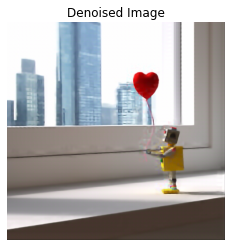

In [12]:
plt.axis('off')
plt.imshow(remove_padding(reconstructed_denoised_img_rgb))
save_path = name + '_' + str(compression_rate) + '.png'
save_image(remove_padding(reconstructed_denoised_img_rgb), save_path)
plt.title('Denoised Image')